
#**Project for Discrete Time Signal Processing**

By:

Avanti Bhandarkar C008

Jay Goyal C017

Dhruv Khandelwal C024

##**Aim:** Use of Mel-frequency cepstral coefficients (MFCCs) in spoof detection



##**Theory:** 

###What are MFCCs

Mel Frequency Cepstral Coefficents (MFCCs) are a way of extracting features from an audio. MFCCs use the MEL scale to divide the frequency band to sub-bands and then extract the Cepstral Coefficents using Discrete Cosine Transform (DCT). MEL scale is based on the way humans distinguish between frequencies which makes it very convenient to process sounds.

###The MEL scale
A MEL scale is a unit of PITCH proposed by Stevens, Volkmann and Newmann in 1937. The MEL scale is a scale of pitches judged by listeners to be equal in distance one from another. Because of how humans perceive sound the MEL scale is a non-linear scale and the distances between the pitches increases with an increase in frequency.

<img src="https://www.researchgate.net/profile/Ying_Hu17/publication/261198223/figure/fig3/AS:669044537565194@1536524056895/The-pitch-scale-and-the-mel-scale.ppm">

###Characteristics of spoofed speech vs natural speech


##**Code:**

###Preprocessing and misc

In [ ]:
import librosa, librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from sklearn.metrics import confusion_matrix
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn import metrics

import scipy
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
import IPython.display as ipd


In [ ]:
#os.chdir("/content/drive/My Drive/ASVspoof2017_V2_train")
#file_spoof="T_1003016.wav"
file_natural="T_1000001.wav"
signal, sr=librosa.load(file_natural)
print('Original sampling rate is',sr,'Hz')
signal, sr=librosa.load(file_natural,sr=16000)
print('The new sampling rate is set to',sr,'Hz')
print('The duration of the current audio sample is',len(signal)/sr,'s')

Original sampling rate is 22050 Hz
The new sampling rate is set to 16000 Hz
The duration of the current audio sample is 2.4215 s


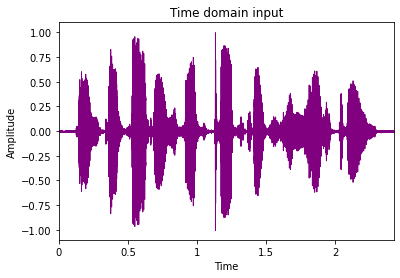

In [ ]:
librosa.display.waveplot(signal,sr=sr,color='purple')
plt.title('Time domain input')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

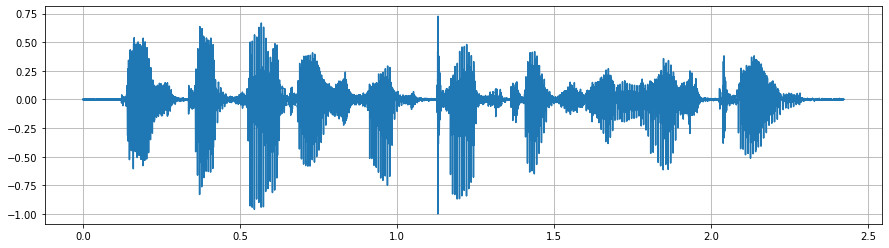

In [ ]:
def normalize_audio(audio):
    audio = audio / np.max(np.abs(audio))
    return audio

signal = normalize_audio(signal)
plt.figure(figsize=(15,4))
plt.plot(np.linspace(0, len(signal) / sr, num=len(signal)), signal)
plt.grid(True)

###Using inbuilt functions

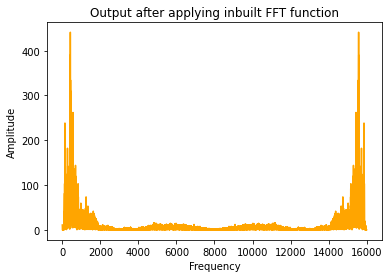

In [ ]:
ft=np.fft.fft(signal)
ft=np.abs(ft)
freq=np.linspace(0,sr,len(signal))
plt.plot(freq,ft,color='orange')
plt.title('Output after applying inbuilt FFT function')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.show()

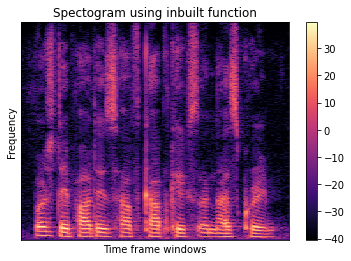

In [ ]:
stft_n=1024
hop_len=256
stft=librosa.core.stft(signal,hop_length=hop_len,n_fft=stft_n)
specgram=librosa.amplitude_to_db(np.abs(stft))
librosa.display.specshow(specgram,sr=sr,hop_length=hop_len,cmap='magma')
plt.title('Spectogram using inbuilt function')
plt.xlabel('Time frame windows')
plt.ylabel('Frequency')
plt.colorbar()
plt.show()

(13, 152)


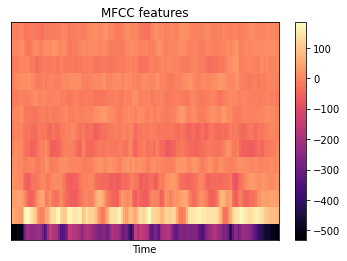

In [ ]:
mfccs=librosa.feature.mfcc(signal,hop_length=hop_len,n_fft=stft_n,n_mfcc=13)
print(mfccs.shape)
librosa.display.specshow(mfccs,sr=sr,hop_length=hop_len,cmap='magma')
plt.title('MFCC features')
plt.xlabel('Time')
plt.colorbar()
plt.show()

###From scratch

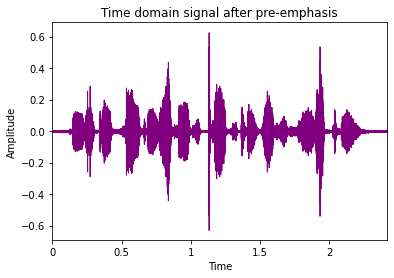

In [ ]:
pre_emphasis = 0.97
emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

librosa.display.waveplot(emphasized_signal,sr=sr,color='purple')
plt.title('Time domain signal after pre-emphasis')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()

In [ ]:
def frame_audio(audio, FFT_size=2048, hop_size=10, sample_rate=44100):
    # hop_size in ms
    
    audio = np.pad(audio, int(FFT_size / 2), mode='reflect')
    frame_len = np.round(sample_rate * hop_size / 1000).astype(int)
    frame_num = int((len(audio) - FFT_size) / frame_len) + 1
    frames = np.zeros((frame_num,FFT_size))
    
    for n in range(frame_num):
        frames[n] = audio[n*frame_len:n*frame_len+FFT_size]
    
    return frames

hop_size = 15 #ms
FFT_size = 2048

audio_framed = frame_audio(emphasized_signal, FFT_size=FFT_size, hop_size=hop_size, sample_rate=sr)
print("Framed audio shape: {0}".format(audio_framed.shape))

FFT_size=2048
hop_size=10
sample_rate=44100

#np.pad(signal, int(FFT_size / 2), mode='reflect').shape

print("First frame:",audio_framed[1],"\n")


print("Last frame:",audio_framed[-1])


Framed audio shape: (162, 2048)
First frame: [-2.56347703e-05 -1.12091063e-03  8.23973096e-06 ... -1.73950102e-05
 -1.45172118e-03  3.69323744e-03] 

Last frame: [ 0.00081146 -0.00117706  0.00110748 ... -0.00011261 -0.00067505
 -0.00036163]


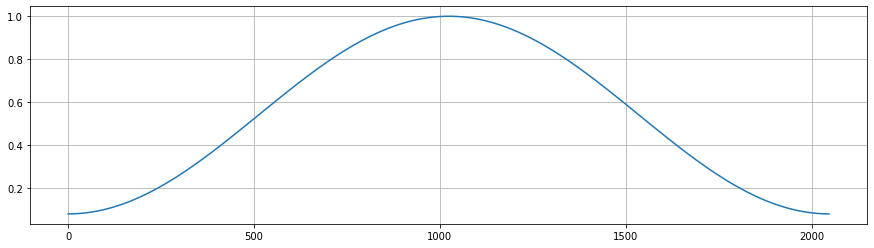

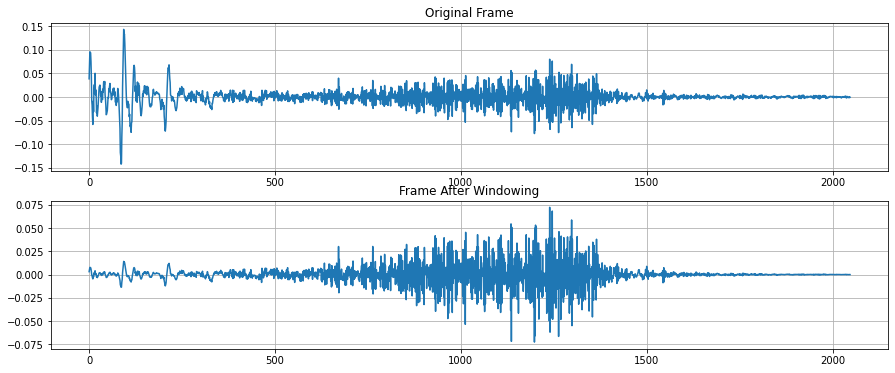

In [ ]:
window = get_window("hamm", FFT_size, fftbins=True)
plt.figure(figsize=(15,4))
plt.plot(window)
plt.grid(True)

audio_win = audio_framed * window

ind = 69
plt.figure(figsize=(15,6))
plt.subplot(2, 1, 1)
plt.plot(audio_framed[ind])
plt.title('Original Frame')
plt.grid(True)
plt.subplot(2, 1, 2)
plt.plot(audio_win[ind])
plt.title('Frame After Windowing')
plt.grid(True)

In [ ]:
audio_winT = np.transpose(audio_win)

audio_fft = np.empty((int(1 + FFT_size // 2), audio_winT.shape[1]), dtype=np.complex64, order='F')

for n in range(audio_fft.shape[1]):
    audio_fft[:, n] = fft.fft(audio_winT[:, n], axis=0)[:audio_fft.shape[0]]

audio_fft = np.transpose(audio_fft)

In [ ]:
audio_power = np.square(np.abs(audio_fft))
print(audio_power.shape)

(162, 1025)


In [ ]:
freq_min = 0
freq_high = sr / 2
mel_filter_num = 10

print("Minimum frequency: {0}".format(freq_min))
print("Maximum frequency: {0}".format(freq_high))

def freq_to_mel(freq):
    return 2595.0 * np.log10(1.0 + freq / 700.0)

def mel_to_freq(mels):
    return 700.0 * (10.0**(mels / 2595.0) - 1.0)

def get_filter_points(fmin, fmax, mel_filter_num, FFT_size, sample_rate=44100):
    fmin_mel = freq_to_mel(fmin)
    fmax_mel = freq_to_mel(fmax)
    
    print("MEL min: {0}".format(fmin_mel))
    print("MEL max: {0}".format(fmax_mel))
    
    mels = np.linspace(fmin_mel, fmax_mel, num=mel_filter_num+2)
    freqs = mel_to_freq(mels)
    
    return np.floor((FFT_size + 1) / sample_rate * freqs).astype(int), freqs

filter_points, mel_freqs = get_filter_points(freq_min, freq_high, mel_filter_num, FFT_size, sample_rate=44100)
filter_points

Minimum frequency: 0
Maximum frequency: 8000.0
MEL min: 0.0
MEL max: 2840.023046708319


array([  0,   8,  18,  32,  48,  69,  96, 129, 170, 223, 288, 371])

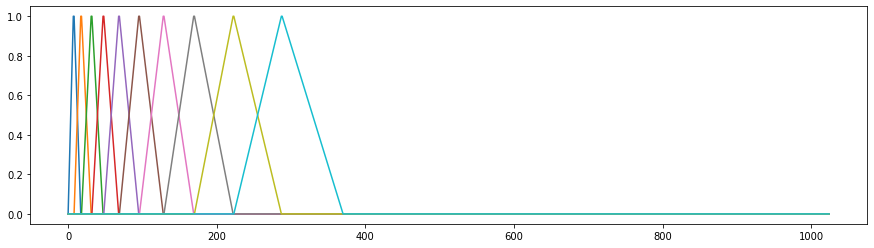

In [ ]:
### Construct the filterbank

def get_filters(filter_points, FFT_size):
    filters = np.zeros((len(filter_points)-2,int(FFT_size/2+1)))
    
    for n in range(len(filter_points)-2):
        filters[n, filter_points[n] : filter_points[n + 1]] = np.linspace(0, 1, filter_points[n + 1] - filter_points[n])
        filters[n, filter_points[n + 1] : filter_points[n + 2]] = np.linspace(1, 0, filter_points[n + 2] - filter_points[n + 1])
    
    return filters

filters = get_filters(filter_points, FFT_size)

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

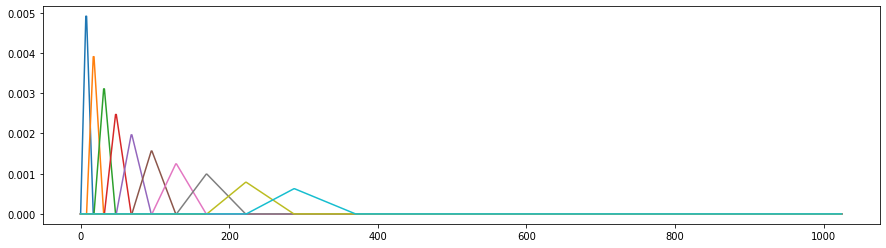

In [ ]:
enorm = 2.0 / (mel_freqs[2:mel_filter_num+2] - mel_freqs[:mel_filter_num])
filters *= enorm[:, np.newaxis]

plt.figure(figsize=(15,4))
for n in range(filters.shape[0]):
    plt.plot(filters[n])

In [ ]:
audio_filtered = np.dot(filters, np.transpose(audio_power))
audio_log = 10.0 * np.log10(audio_filtered)
audio_log.shape

(10, 162)

In [ ]:
def dct(dct_filter_num, filter_len):
    basis = np.empty((dct_filter_num,filter_len))
    basis[0, :] = 1.0 / np.sqrt(filter_len)
    
    samples = np.arange(1, 2 * filter_len, 2) * np.pi / (2.0 * filter_len)

    for i in range(1, dct_filter_num):
        basis[i, :] = np.cos(i * samples) * np.sqrt(2.0 / filter_len)
        
    return basis

dct_filter_num = 15

dct_filters = dct(dct_filter_num, mel_filter_num)

cepstral_coefficents = np.dot(dct_filters, audio_log)
cepstral_coefficents.shape

(15, 162)

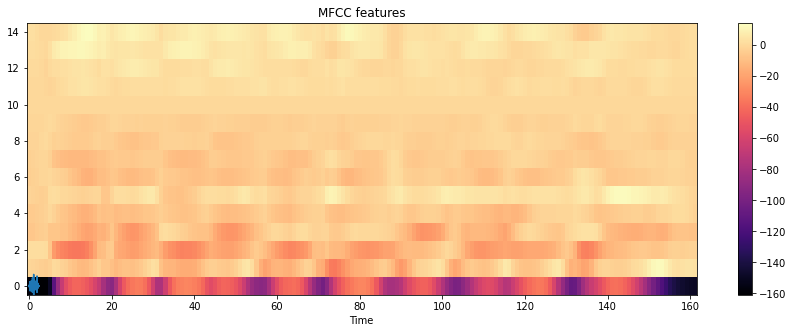

In [ ]:
cepstral_coefficents[:, 0]

plt.figure(figsize=(15,5))
plt.plot(np.linspace(0, len(emphasized_signal) / sr, num=len(emphasized_signal)), emphasized_signal)
plt.imshow(cepstral_coefficents, aspect='auto', origin='lower',cmap='magma')
plt.title('MFCC features')
plt.xlabel('Time')
plt.colorbar()

###Classification of samples

In [ ]:
from IPython.display import Audio
os.chdir("/content/drive/My Drive/ASVspoof2017_V2_train")
filenatural="T_1000101.wav"
filespoof="T_1002111.wav"
signalnatural, sr=librosa.load(filenatural,sr=16000)
signalspoof, sr=librosa.load(filespoof,sr=16000)
print(sr)

In [ ]:
#natural speech
Audio(signalnatural,rate=sr)

In [ ]:
#spoofed speech
Audio(signalspoof,rate=sr)

In [ ]:
#DONT RUN THIS AGAIN
cnt1=0
print(os.listdir())
names=os.listdir()
data={}
for i in names:
  if(not ("(" in i)):
    try:
      data[i]=librosa.load(i,sr=16000)[0]
    except:
      pass
    cnt1=cnt1+1
    print(cnt1)
print(data)

In [ ]:
#DO NOT RUN THIS AGAIN
import pickle
f = open("converted.pkl","wb")
pickle.dump(data,f)
f.close()

In [ ]:

#next time start execution from here
labels=pd.read_csv("/content/drive/My Drive/spoof1.csv")
print(labels.columns)
filt=labels.loc[:]["status"]=="genuine"
for i in range(0,len(labels)):
  if(labels.loc[i]["status"]=="genuine"):
      labels.loc[i]["status"]=1
  else:
    labels.loc[i]["status"]=0
print(labels)

In [ ]:
import pickle
with open('converted.pkl', 'rb') as handle:
    data1 = pickle.load(handle)

In [ ]:
sorted=[]
for i in labels["file"]:
  try:
    sorted.append(data1[i])
  except:
    print(labels[labels["file"]==i])
print(len(sorted))
#labels=labels.drop(labels.index[802])
labels=labels.drop(labels.index[1644])
labels=labels.drop(labels.index[2213])
print(len(labels))
labels["signal"]=sorted

In [ ]:
y=labels.status
x_train,x_test,y_train,y_test=sklearn.model_selection.train_test_split(labels,y,train_size=0.4)
x_train_natural=x_train[x_train.status==1]
x_train_spoof=x_train[x_train.status==0]
x_test_natural=x_test[x_test.status==1]
x_test_spoof=x_test[x_test.status==0]
print(x_train_natural.columns)

In [ ]:
k=0
MFCC_natural=librosa.feature.mfcc(x_train_natural.signal.iloc[0],sr=16000,n_mfcc=20)
for sig in x_train_natural.signal[1:]:
  mfccs=librosa.feature.mfcc(sig,sr=16000,n_mfcc=20)
  MFCC_natural=np.hstack((MFCC_natural,mfccs))
  print(k)
  k=k+1
MFCC_natural=np.array(MFCC_natural)
MFCC_natural=MFCC_natural.T

k=0
MFCC_spoof=librosa.feature.mfcc(x_train_spoof.signal.iloc[0],sr=16000,n_mfcc=20)
for sig in x_train_spoof.signal[1:]:
  mfccs=librosa.feature.mfcc(sig,sr=16000,n_mfcc=20)
  MFCC_spoof=np.hstack((MFCC_spoof,mfccs))
  print(k)
  k=k+1
MFCC_spoof=MFCC_spoof.T


print(MFCC_natural.shape)
print(MFCC_spoof.shape)
labels_all=np.vstack((np.ones((MFCC_natural.shape[0],1)),np.zeros((MFCC_spoof.shape[0],1))))
features_all=np.vstack((MFCC_natural,MFCC_spoof))
print(labels_all)
print(features_all.shape)

In [ ]:
#DONT RUN AGAIN

np.savetxt('train_features.csv', features_all, delimiter=',')
np.savetxt('train_labels.csv', labels_all, delimiter=',')
np.savetxt('train_natural_features.csv', MFCC_natural, delimiter=',')
np.savetxt('train_spoof_features.csv', MFCC_spoof, delimiter=',')

In [ ]:
#RUN FROM HERE
features_all = np.loadtxt('train_features.csv', delimiter=',')
labels_all = np.loadtxt('train_labels.csv', delimiter=',')
MFCC_spoof = np.loadtxt('train_spoof_features.csv', delimiter=',')
MFCC_natural = np.loadtxt('train_natural_features.csv', delimiter=',')

In [ ]:
#Data visualization
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc1 = StandardScaler()
sc.fit(MFCC_natural)
MFCC_natural=sc.transform(MFCC_natural)
sc1.fit(MFCC_spoof)
MFCC_spoof=sc1.transform(MFCC_spoof)
pca = PCA(n_components=2)
nat_r = pca.fit(MFCC_natural).transform(MFCC_natural)
sp_r=pca.fit(MFCC_spoof).transform(MFCC_spoof)
#plt.scatter(nat_r[:,0],nat_r[:,1],label="real")
plt.scatter(nat_r[:,0],nat_r[:,1],label="real")
plt.scatter(sp_r[:,0],sp_r[:,1],label="spoof",alpha=1)
plt.legend()
plt.show()

In [ ]:
#TEST SCRIPT
k=0
MFCC_natural=librosa.feature.mfcc(x_test_natural.signal.iloc[0],sr=16000,n_mfcc=20)
for sig in x_test_natural.signal[1:200]:
  mfccs=librosa.feature.mfcc(sig,sr=16000,n_mfcc=20)
  MFCC_natural=np.hstack((MFCC_natural,mfccs))
  k=k+1
MFCC_natural=np.array(MFCC_natural)
MFCC_natural=MFCC_natural.T
k=0
MFCC_spoof=librosa.feature.mfcc(x_test_spoof.signal.iloc[0],sr=16000,n_mfcc=20)
for sig in x_test_spoof.signal[1:200]:
  mfccs=librosa.feature.mfcc(sig,sr=16000,n_mfcc=20)
  MFCC_spoof=np.hstack((MFCC_spoof,mfccs))
  k=k+1
MFCC_spoof=MFCC_spoof.T
labels_all_test=np.vstack((np.ones((MFCC_natural.shape[0],1)),np.zeros((MFCC_spoof.shape[0],1))))
features_all_test=np.vstack((MFCC_natural,MFCC_spoof))

In [ ]:
#DONT RUN TWICE
np.savetxt('test_features.csv', features_all_test, delimiter=',')
np.savetxt('test_labels.csv', labels_all_test, delimiter=',')

In [ ]:
#DONT RUN TWICE
np.savetxt('test_features.csv', features_all_test, delimiter=',')
np.savetxt('test_labels.csv', labels_all_test, delimiter=',')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5)
neigh.fit(features_all, np.array(labels_all))
print("train done")
y_predknn = neigh.predict(features_all_test)
print("accuracy using knn is")
print(1-sum(abs(y_predknn-labels_all_test.reshape(1,labels_all_test.shape[0]).tolist()[0]))/features_all_test.shape[0])
conmat=confusion_matrix(labels_all_test, y_predknn)
print("confusion matrix is:")
print(conmat)
tn, fp, fn, tp = conmat.ravel()
print("true negatives:",tn)
print("false positives:",fp)
print("false negatives:",fn)
print("true positives:",tp)

##**Discussion and Conclusion:**